# Autoencoders

In [1]:
## just for debug
import os, sys
ROOT_PATH = os.path.dirname(os.getcwd())
if ROOT_PATH not in sys.path: sys.path.insert(1,str(ROOT_PATH))

'e:\\dherrera\\OneDrive - Universidad Tecnológica de Bolívar\\TesisAnomDetect'

Params

In [2]:
random_state = 123
scoring_metric = "roc_auc"
# dataset_name="diabetes"
dataset_name="credit_risk"
contamination = 0.1

Load librerias

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from lib_anomaly.utils import load_dataset

... Loading: lib_anomaly.models
... Loading: lib_anomaly.utils


Load data

In [4]:
data, target = load_dataset(dataset_name=dataset_name, random_state=random_state, ROOT_PATH=ROOT_PATH)
data.head()

,class,classLabel,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
131,1,bad,<0,36.0,delayed previously,education,6887.0,<100,1<=X<4,4.0,...,3.0,life insurance,29.0,stores,own,1.0,skilled,1.0,yes,yes
203,1,bad,<0,12.0,existing paid,retraining,902.0,<100,4<=X<7,4.0,...,4.0,life insurance,21.0,none,rent,1.0,skilled,1.0,none,yes
50,0,good,0<=X<200,24.0,delayed previously,furniture/equipment,2333.0,no known savings,<1,4.0,...,2.0,life insurance,29.0,bank,own,1.0,unskilled resident,1.0,none,yes
585,1,bad,<0,18.0,existing paid,furniture/equipment,2039.0,<100,1<=X<4,1.0,...,4.0,real estate,20.0,bank,rent,1.0,skilled,1.0,none,yes
138,0,good,0<=X<200,15.0,critical/other existing credit,radio/tv,2728.0,no known savings,4<=X<7,4.0,...,2.0,real estate,35.0,bank,own,3.0,skilled,1.0,yes,yes


In [5]:
features = list(data.columns)[2:]
print(f"{target=}\nNo features={len(features)} -> {features}\n{data.shape=}")

target='class'
No features=20 -> ['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker']
data.shape=(1000, 22)


make `X` and `y`

In [6]:
X = data.drop([target, target+"Label"], axis=1).copy()
y = data[target].copy()
print(f"{X.shape=}\n{y.shape=}\n\n{target=} distribution")
print(pd.DataFrame(
    [dict(y.value_counts().sort_index())
    , dict(y.value_counts(normalize=True).sort_index()*100)
    ]
    , index=["freq","%"]
).T.to_string())
X.head()

X.shape=(1000, 20)
y.shape=(1000,)

target='class' distribution
    freq     %
0  700.0  70.0
1  300.0  30.0


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
131,<0,36.0,delayed previously,education,6887.0,<100,1<=X<4,4.0,male single,none,3.0,life insurance,29.0,stores,own,1.0,skilled,1.0,yes,yes
203,<0,12.0,existing paid,retraining,902.0,<100,4<=X<7,4.0,male mar/wid,none,4.0,life insurance,21.0,none,rent,1.0,skilled,1.0,none,yes
50,0<=X<200,24.0,delayed previously,furniture/equipment,2333.0,no known savings,<1,4.0,male single,none,2.0,life insurance,29.0,bank,own,1.0,unskilled resident,1.0,none,yes
585,<0,18.0,existing paid,furniture/equipment,2039.0,<100,1<=X<4,1.0,female div/dep/mar,none,4.0,real estate,20.0,bank,rent,1.0,skilled,1.0,none,yes
138,0<=X<200,15.0,critical/other existing credit,radio/tv,2728.0,no known savings,4<=X<7,4.0,male single,guarantor,2.0,real estate,35.0,bank,own,3.0,skilled,1.0,yes,yes


Preprocess

In [7]:
from lib_anomaly.utils import fix_data_type

from sklearn.pipeline           import Pipeline
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import MinMaxScaler, OneHotEncoder
from sklearn.compose            import ColumnTransformer
from category_encoders.binary   import BinaryEncoder

In [8]:
data, cols_num, cols_cat_high, cols_cat_low = fix_data_type(
                                    features=features
                                    , data=data
                                )
print(f"{cols_num=}\n{cols_cat_high=}\n{cols_cat_low=}")

cols_num=['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
cols_cat_high=[]
cols_cat_low=['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [9]:
## pipeline
process_num = Pipeline(steps=[
                        ("impute_mean", SimpleImputer(missing_values=np.nan, strategy="median")),
                        ("scale_minmax", MinMaxScaler((0,1)))
                    ]
                )
process_low_cat = Pipeline(steps=[
                        ("impute_constant", SimpleImputer(missing_values=np.nan, strategy="most_frequent"))
                        , ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
                    ]
                )
process_high_cat = Pipeline(steps=[
                        ("impute_constant", SimpleImputer(missing_values=np.nan, strategy="most_frequent"))
                        , ("binary", BinaryEncoder())
                        , ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))       ##agregado posterior
                    ]
                )
preprocess_vars = ColumnTransformer(
                    [
                        ("cat_low_dimension", process_low_cat, cols_cat_low)
                        , ("cat_high_dimension", process_high_cat, cols_cat_high)
                        , ("numerical", process_num, cols_num)
                    ]
            )
preprocess_vars

ColumnTransformer(transformers=[('cat_low_dimension',
                                 Pipeline(steps=[('impute_constant',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['checking_status', 'credit_history',
                                  'purpose', 'savings_status', 'employment',
                                  'personal_status', 'other_parties',
                                  'property_magnitude', 'other_payment_plans',
                                  'housin...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary', BinaryEncoder()),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 []),
                                ('numerical',
                                 Pipeline(steps=[('impute_mean',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale_minmax',
                                                  MinMaxScaler())]),
                                 ['duration', 'credit_amount',
                                  'installment_commitment', 'residence_since',
                                  'age', 'existing_credits',
                                  'num_dependents'])])

In [10]:
preprocess_vars.fit(X)
X_ = preprocess_vars.transform(data[features])
print(f"{X_.shape=}")

X_.shape=(1000, 61)


Split

In [11]:
from sklearn.model_selection    import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
                                                    X_
                                                    , y
                                                    , test_size=0.1
                                                    , stratify=y
                                                    , random_state=random_state
                                                )
print(f"{x_train.shape=}, {x_test.shape=}, {y_train.shape=}, {y_test.shape=}")

x_train.shape=(900, 61), x_test.shape=(100, 61), y_train.shape=(900,), y_test.shape=(100,)


Realizar clasificacion

In [13]:
from sklearn.model_selection    import cross_val_score, cross_val_predict, StratifiedKFold
from lib_anomaly.models         import load_classifiers_models, get_metrics_report
from lib_anomaly.plots          import plot_metrics

... Loading: lib_anomaly.plots


In [14]:
Before = dict()
classifiers = load_classifiers_models()
pBar = tqdm(classifiers.items())
for name,clf in pBar:
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
    pBar.set_description(name)
    score = cross_val_score(
                            estimator=clf
                            , X=x_train
                            , y=y_train
                            , scoring=scoring_metric
                            , cv=cv
                        )
    y_pred = cross_val_predict(
                            estimator=clf
                            , X=x_train
                            , y=y_train
                            , cv=cv
                )
    cla_report = get_metrics_report(y_true=y_train, y_pred=y_pred)
    cla_report.update({f"cv_{scoring_metric}_mean":score.mean(),f"cv_{scoring_metric}_std":score.std()})
    # resp[name] = {"mean":score.mean(), "std":score.std()}
    Before[name] = cla_report

AB: 100%|██████████| 6/6 [00:09<00:00,  1.50s/it] 


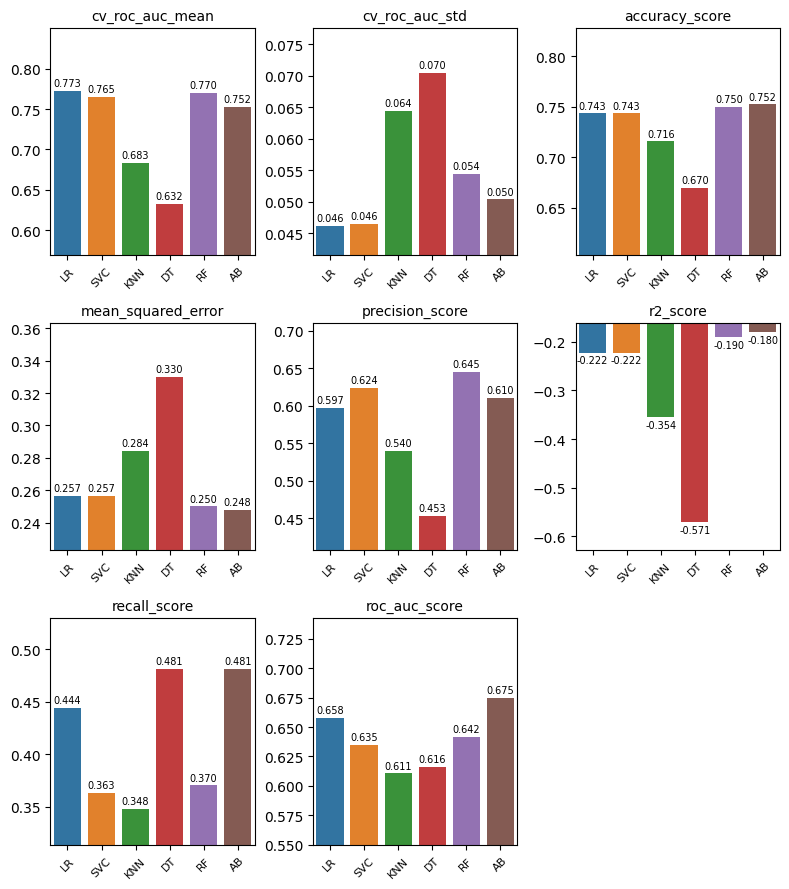

In [15]:
plot_metrics(
            results=Before
            , ncol=3
            , show_title=False
            # , out_path=out_path
            # , fName="metrics_before"
        )

Autoencoders from pyod

In [16]:
from pyod.models.auto_encoder import AutoEncoder
from lib_anomaly.anomaly import make_hidden_layers

... Loading: lib_anomaly.anomaly


In [17]:
nn_layers = make_hidden_layers(no_features=len(features))
print(f"{contamination=}, {nn_layers=}")

contamination=0.1, nn_layers=[20, 14, 6, 14, 20]


In [18]:
%%time
detector = AutoEncoder(
        hidden_neurons=nn_layers
        , verbose=0
        , contamination=contamination
    )
detector.fit(X_)

32/32 [==============================] - 0s 1ms/step
CPU times: total: 18.9 s
Wall time: 13 s


AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[20, 14, 6, 14, 20],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000001F9FF3EA280>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=0)

In [19]:
anom            = detector.labels_
res_decision    = detector.decision_function(X_)
proba           = detector.predict_proba(X_)

32/32 [==============================] - 0s 903us/step


In [20]:
print(f"No of anomaly = {sum(anom)} {round(sum(anom)/len(anom)*100,4)}%")
tmp = pd.DataFrame(anom, columns=["anom"])
dict(tmp.value_counts()), dict(tmp.value_counts(normalize=True))
pd.concat([tmp.head(10).reset_index(), tmp.tail(10).reset_index()], axis=1)

No of anomaly = 100 10.0%


,index,anom,index,anom
0,0,0,990,0
1,1,1,991,1
2,2,0,992,0
3,3,0,993,0
4,4,0,994,0
5,5,0,995,0
6,6,0,996,0
7,7,0,997,0
8,8,0,998,0
9,9,0,999,0


In [21]:
norm_index = [i for i,a in enumerate(anom) if a==0]
anom_index = [i for i,a in enumerate(anom) if a==1]
print(f"{norm_index[:20]=}")
print(f"{anom_index[:20]=}")

norm_index[:20]=[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 19, 20, 21, 22, 23]
anom_index[:20]=[1, 12, 14, 18, 24, 43, 67, 82, 90, 91, 136, 139, 141, 146, 147, 154, 158, 166, 168, 179]


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

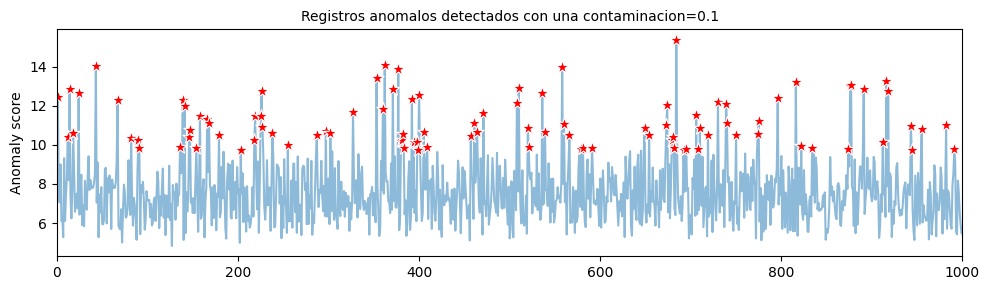

In [23]:
plt.figure(figsize=(10,3))
g = sns.lineplot(x=range(len(res_decision)), y=res_decision, zorder=0, alpha=0.5)
g = sns.scatterplot(x=anom_index, y=res_decision[anom_index], color="red", zorder=1, marker="*", s=100)
g.set(xlim=(0,len(res_decision)), ylabel="Anomaly score")
plt.title(f"Registros anomalos detectados con una contaminacion={contamination}", size=10)
plt.tight_layout()
plt.show()

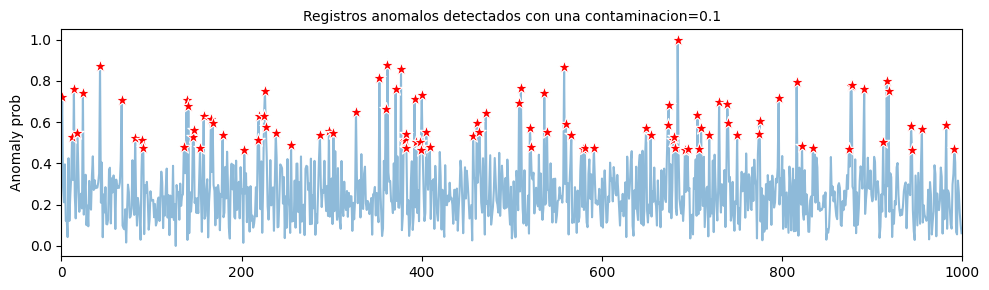

In [24]:
## plot de anomalias por probabilidad
plt.figure(figsize=(10,3))
g = sns.lineplot(x=range(len(proba)), y=proba[:,1], zorder=0, alpha=0.5)
g = sns.scatterplot(x=anom_index, y=proba[:,1][anom_index], color="red", zorder=1, marker="*", s=100)
g.set(xlim=(0,len(res_decision)), ylabel="Anomaly prob")
plt.title(f"Registros anomalos detectados con una contaminacion={contamination}", size=10)
plt.tight_layout()
plt.show()

In [25]:
X_A,y_A, = X_[norm_index],y.iloc[norm_index]
print(f"{X_A.shape=}\n{y_A.shape=}\n\n{target=} distribution")
print(pd.DataFrame(
    [dict(y_A.value_counts().sort_index())
    , dict(y_A.value_counts(normalize=True).sort_index()*100)
    ]
    , index=["freq","%"]
).T.to_string())

X_A.shape=(900, 61)
y_A.shape=(900,)

target='class' distribution
    freq          %
0  633.0  70.333333
1  267.0  29.666667


In [26]:
x_trainA, x_testA, y_trainA, y_testA = train_test_split(
                                                    X_A
                                                    , y_A
                                                    , test_size=0.1
                                                    , stratify=y_A
                                                    , random_state=random_state
                                                )
print(f"{x_trainA.shape=}, {x_testA.shape=}, {y_trainA.shape=}, {y_testA.shape=}")

x_trainA.shape=(810, 61), x_testA.shape=(90, 61), y_trainA.shape=(810,), y_testA.shape=(90,)


In [27]:
After = dict()

pBar = tqdm(classifiers.items())
for name,clf in pBar:
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
    pBar.set_description(name)
    scoreA = cross_val_score(
                            estimator=clf
                            , X=x_trainA
                            , y=y_trainA
                            , scoring=scoring_metric
                            , cv=cv
                        )
    y_predA = cross_val_predict(
                            estimator=clf
                            , X=x_trainA
                            , y=y_trainA
                            , cv=cv
                )
    cla_reportA = get_metrics_report(y_true=y_trainA, y_pred=y_predA)
    cla_reportA.update({f"cv_{scoring_metric}_mean":scoreA.mean(),f"cv_{scoring_metric}_std":scoreA.std()})
    # resp[name] = {"mean":score.mean(), "std":score.std()}
    After[name] = cla_reportA

AB: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it] 


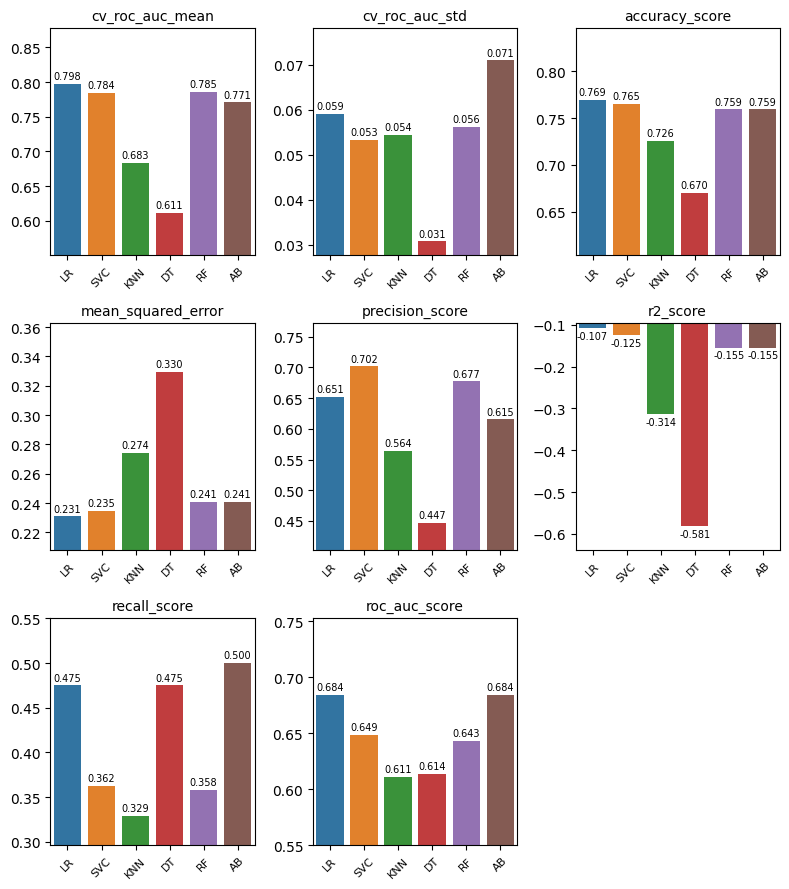

In [28]:
plot_metrics(
            results=After
            , ncol=3
            , show_title=False
            # , out_path=out_path
            # , fName="metrics_before"
        )

In [29]:
from lib_anomaly.plots import plot_comparacion_resultados

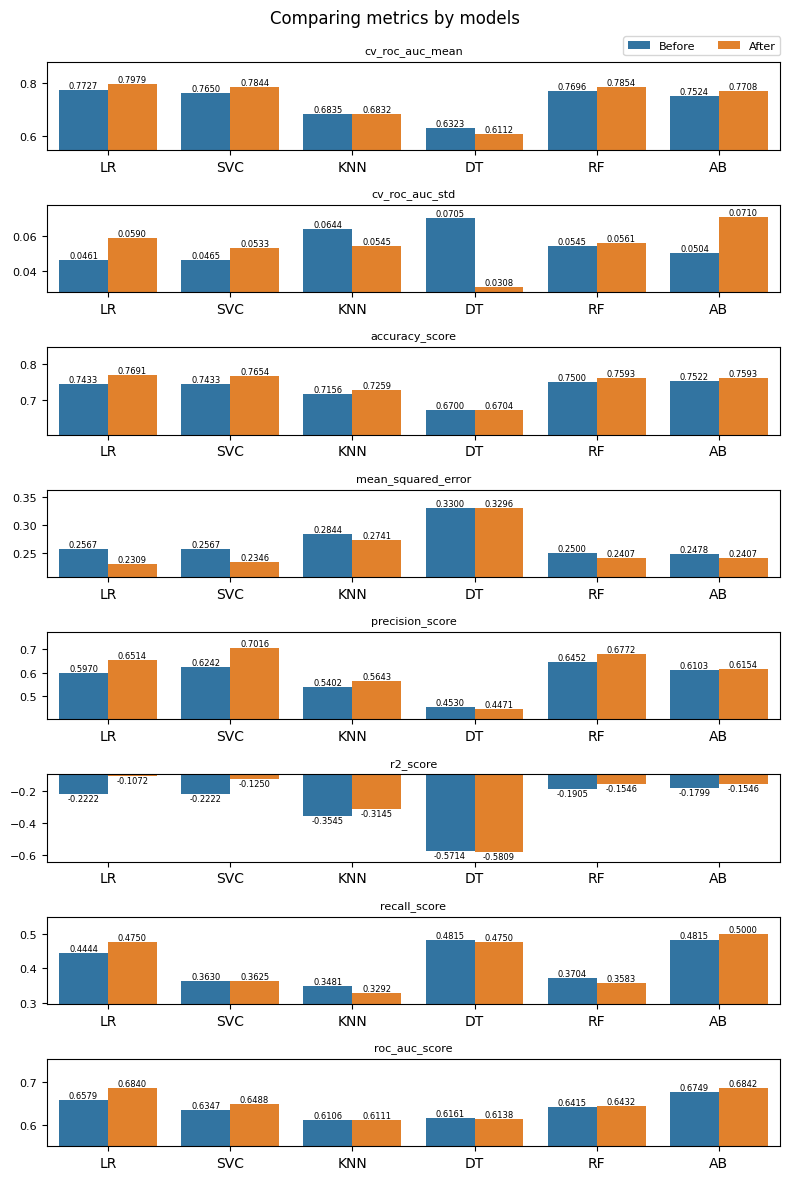

In [30]:
plot_comparacion_resultados(
                    linea_base=Before
                    , experimento=After
                )